# Libraries

In [1]:
import os
import re
import pickle
import string
from pprint import pprint
from math import sqrt, pow, exp

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

from datasets import load_dataset

import emoji
import contractions
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import pyLDAvis.gensim
import pyLDAvis

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import fasttext

plt.style.use('seaborn-v0_8-pastel')

## Amazon US reviews

Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. 

Each Dataset contains the following columns: 
- marketplace - 2 letter country code of the marketplace where the review was written. 
- customer_id - Random identifier that can be used to aggregate reviews written by a single author. 
- review_id - The unique ID of the review. 
- product_id - The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id. 
- product_parent - Random identifier that can be used to aggregate reviews for the same product. 
- product_title - Title of the product. 
- product_category - Broad product category that can be used to group reviews (also used to group the dataset into coherent parts). 
- star_rating - The 1-5 star rating of the review. 
- helpful_votes - Number of helpful votes. total_votes - Number of total votes the review received. 
- vine - Review was written as part of the Vine program. 
- verified_purchase - The review is on a verified purchase. 
- review_headline - The title of the review. 
- review_body - The review text. 
- review_date - The date the review was written.

Visit this [site](https://huggingface.co/datasets/amazon_us_reviews) for more information.

# Introduction

We're going to build a exploratory data analysis (EDA) notebook. We'll explore different kind of aspects from the following questions:
- How big is this data set?
- What fields can we find here and what they mean?
- Does this data set contain duplicated data?
- What is the data distribution by field?
- Do these fields contain nulls? How can we treat them?
- Are these fields correlated? What decisions can we make based on this?

We might answer some or all of these questions, however we'll put more enphasis on text data. For text data, we can formulate the following questions:
- How big is it? How many documents and words do we have? What is the vocabulary size?
- How long are the documents?
- Are there any missings or empty texts?
- Are there any special character in the data or emoticons?
- Are there any spelling mistakes in the data?
- What are some common words or phrases in general or by any specific category or label?
- Are there any pre-defined categories or topics associated with the text data?
- Are there any trends or patterns over time?

We're also going to explore different kind of text representations and how they're visualized.

Finally, we're going to explore some topics found on the data.

# Load data set

In [263]:
english_dataset = load_dataset('amazon_us_reviews', 'Video_Games_v1_00')

Found cached dataset amazon_us_reviews (C:/Users/Rodrigo/.cache/huggingface/datasets/amazon_us_reviews/Video_Games_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

In [264]:
# for this exercise we're going to select just a sample of the data
sample_size = 5_000
df = english_dataset['train'].to_pandas().sample(sample_size, random_state=18)
print(f"Sample size: {round(sample_size/english_dataset['train'].num_rows*100,2)}%")

Sample size: 0.28%


In [267]:
# save data for further analysis
df.to_parquet('../data/df_amazon_reviews_sample_5k.gzip', compression='gzip')

In [2]:
# load data
df = pd.read_parquet('../data/df_amazon_reviews_sample_5k.gzip')

# Helping functions

# Exploratory data analysis

In [269]:
print(f'Number of documents in the dataset: {df.shape[0]}')
print(f'Number of fields in the dataset: {df.shape[1]}')

Number of documents in the dataset: 10000
Number of fields in the dataset: 15


In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1660627 to 113950
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        10000 non-null  object
 1   customer_id        10000 non-null  object
 2   review_id          10000 non-null  object
 3   product_id         10000 non-null  object
 4   product_parent     10000 non-null  object
 5   product_title      10000 non-null  object
 6   product_category   10000 non-null  object
 7   star_rating        10000 non-null  int32 
 8   helpful_votes      10000 non-null  int32 
 9   total_votes        10000 non-null  int32 
 10  vine               10000 non-null  int64 
 11  verified_purchase  10000 non-null  int64 
 12  review_headline    10000 non-null  object
 13  review_body        10000 non-null  object
 14  review_date        10000 non-null  object
dtypes: int32(3), int64(2), object(10)
memory usage: 1.4+ MB


We notice from the feature report that some variables are binary like 'vine' and 'verified_purchase'.
No nulls detected in dataset

# Field analysis

In [271]:
# check empty review bodies

(df.review_body.str.len() == 0).value_counts()

False    10000
Name: review_body, dtype: int64

In [272]:
# check unique values

for field in df.columns:
    print(f"There are(is) {df[field].nunique():,} unique value(s) for {field}")

There are(is) 1 unique value(s) for marketplace
There are(is) 9,841 unique value(s) for customer_id
There are(is) 10,000 unique value(s) for review_id
There are(is) 6,065 unique value(s) for product_id
There are(is) 5,931 unique value(s) for product_parent
There are(is) 5,130 unique value(s) for product_title
There are(is) 1 unique value(s) for product_category
There are(is) 5 unique value(s) for star_rating
There are(is) 80 unique value(s) for helpful_votes
There are(is) 106 unique value(s) for total_votes
There are(is) 2 unique value(s) for vine
There are(is) 2 unique value(s) for verified_purchase
There are(is) 7,577 unique value(s) for review_headline
There are(is) 9,717 unique value(s) for review_body
There are(is) 3,437 unique value(s) for review_date


In [273]:
# check features with few unique values

print(f"Unique values in market place are: {df['marketplace'].unique()}")
print(f"Unique values in product category are: {df['product_category'].unique()}")
print(f"Unique values in star rating are: {sorted(df['star_rating'].unique())}")
print(f"Unique values in vine are: {sorted(df['vine'].unique())}")
print(f"Unique values in verified purchase are: {sorted(df['verified_purchase'].unique())}")

Unique values in market place are: ['US']
Unique values in product category are: ['Video Games']
Unique values in star rating are: [1, 2, 3, 4, 5]
Unique values in vine are: [0, 1]
Unique values in verified purchase are: [0, 1]


We'll remove market place and product category when creating the ML feature data set. This situation is obvious since we have selected US amazon reviews and just for the video game product category. Vine and verified_purchase are expected to be binary because of the variable definition

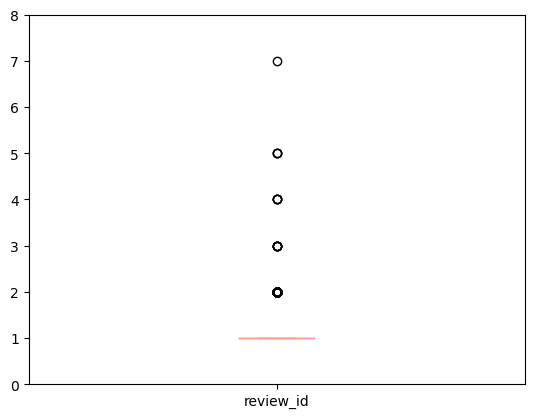

In [274]:
# reviews by customer
df.groupby('customer_id')['review_id'].count().plot(kind='box')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

In [275]:
df.groupby('customer_id')['review_id'].count().describe(percentiles=[.25,.5,.75,.9,.95,.99]).apply(lambda x: f"{x:,.3f}")

count    9,841.000
mean         1.016
std          0.162
min          1.000
25%          1.000
50%          1.000
75%          1.000
90%          1.000
95%          1.000
99%          2.000
max          7.000
Name: review_id, dtype: object

Up to percentile 99% we can find customers doing up to 3 reviews. There are some outliers in the dataset

In [276]:
# sample of reviews done by the customer with highest number of reviews
customers = df.groupby('customer_id')['review_id'].count()
outlier = customers[customers == 52].index[0]
df[df.customer_id == outlier].sample(10, random_state=18)[['review_id','customer_id','review_headline','review_body','review_date']]

IndexError: index 0 is out of bounds for axis 0 with size 0

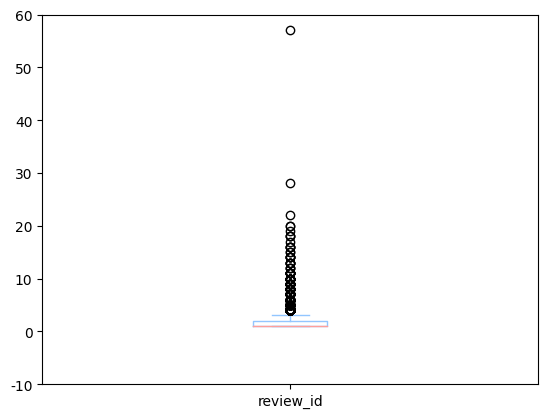

In [ ]:
# check amount of reviews by product

df.groupby('product_id')['review_id'].count().plot(kind='box')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

In [277]:
df.groupby('product_id')['review_id'].count().describe(percentiles=[.25,.5,.75,.9,.95,.99]).apply(lambda x: f"{x:,.3f}")

count    6,065.000
mean         1.649
std          1.778
min          1.000
25%          1.000
50%          1.000
75%          2.000
90%          3.000
95%          4.000
99%          9.000
max         57.000
Name: review_id, dtype: object

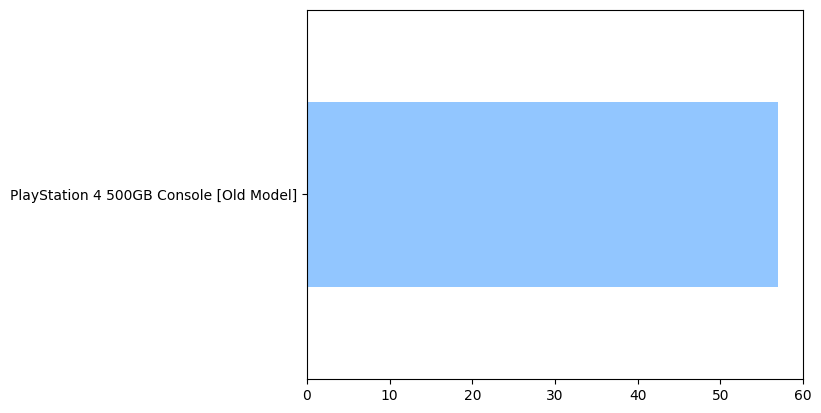

In [278]:
# sample of reviews done by the customer with highest number of reviews
products = df.groupby('product_id')['review_id'].count()
outliers = products[products >= 43].index.values
df[df.product_id.isin(outliers)].product_title.value_counts().sort_values(ascending=True).tail(20).plot(kind='barh')
plt.gca().set_xticks(plt.gca().get_xticks())
plt.gca().set_xticklabels([f'{x:,.0f}' for x in plt.gca().get_xticks()]);

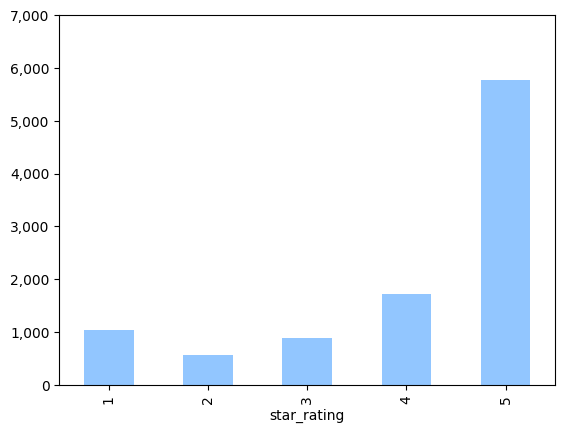

In [279]:
# check number of reviews for star rating

df.groupby('star_rating')['review_id'].count().plot(kind='bar')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

There's a clear evidence that there's a big number of videogames that are great games.

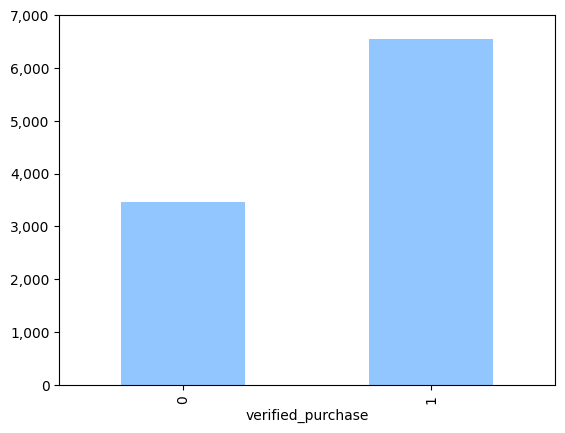

In [280]:
# check reviews by verified purchase

df.groupby('verified_purchase')['review_id'].count().plot(kind='bar')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(f'{x:,.0f}' for x in plt.gca().get_yticks());

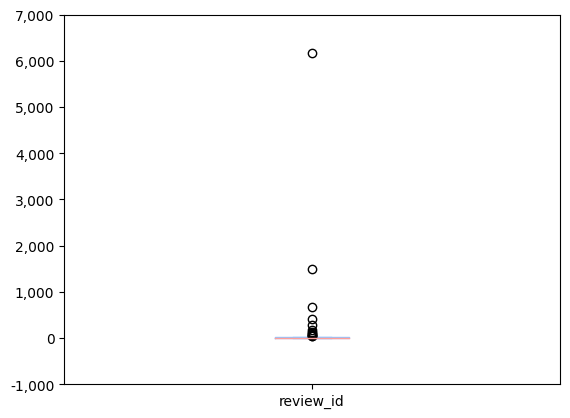

In [281]:
# check amount of reviews by helpful votes

df.groupby('helpful_votes')['review_id'].count().plot(kind='box')
plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

In [282]:
df.groupby('helpful_votes')['review_id'].count().describe(percentiles=[.25,.5,.75,.9,.95,.99]).apply(lambda x: f"{x:,.3f}")

count       80.000
mean       125.000
std        708.881
min          1.000
25%          1.000
50%          2.000
75%         11.500
90%         78.400
95%        276.550
99%      2,466.590
max      6,163.000
Name: review_id, dtype: object

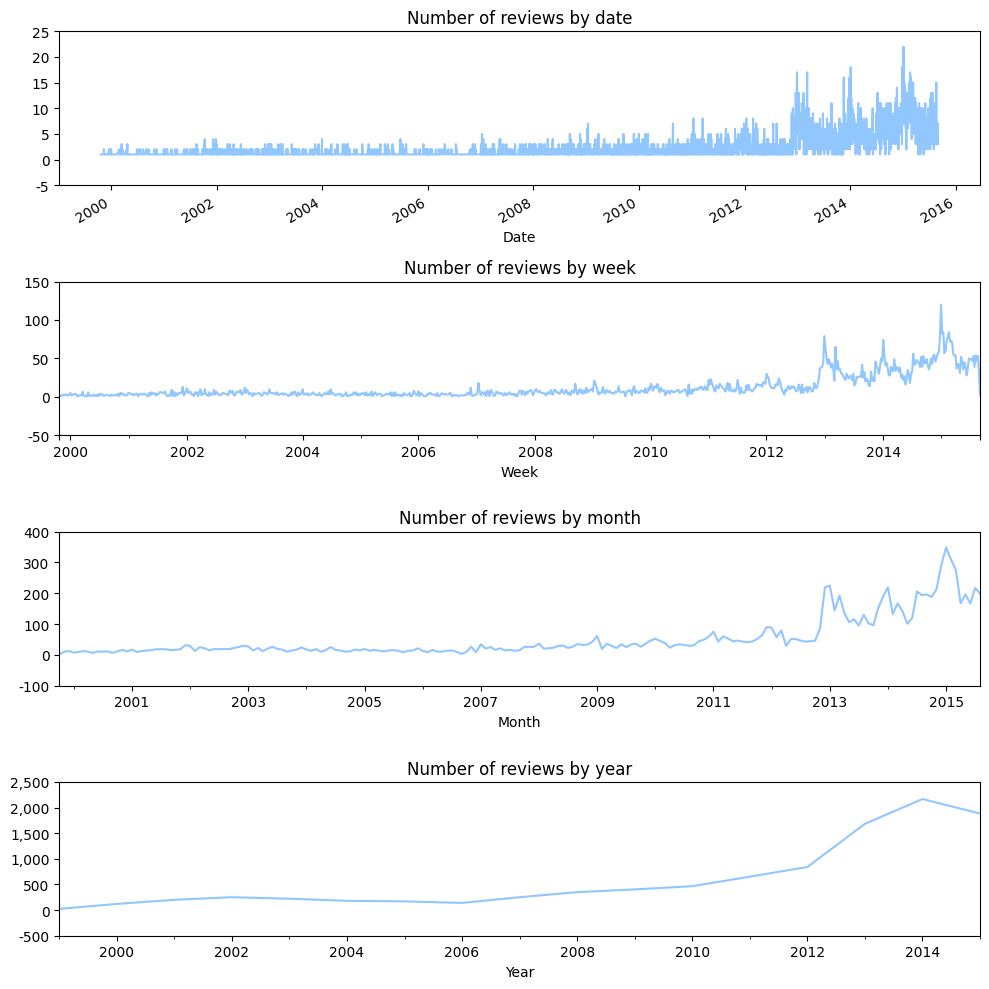

In [283]:
# check amount of reviews by date dimension
df['review_date'] = df.review_date.astype('datetime64[ns]')
df['review_week'] = df.review_date.dt.to_period('W')
df['review_month'] = df.review_date.dt.to_period('M')
df['review_year'] = df.review_date.dt.to_period('Y')

fig, axs = plt.subplots(4,1)
date_columns = ['review_date', 'review_week', 'review_month', 'review_year']
for i, column in enumerate(date_columns):
    df.groupby(column)['review_id'].count().plot(kind='line',figsize=(10,10), ax=axs[i])
    axs[i].set_xlabel(f"{(column.split('_')[1]).capitalize()}")
    axs[i].set_yticks(axs[i].get_yticks())
    axs[i].set_yticklabels(f'{x:,.0f}' for x in axs[i].get_yticks())
    axs[i].set_title(f"Number of reviews by {column.split('_')[1]}")
plt.tight_layout();

## Explore text fields

### Word size distribution

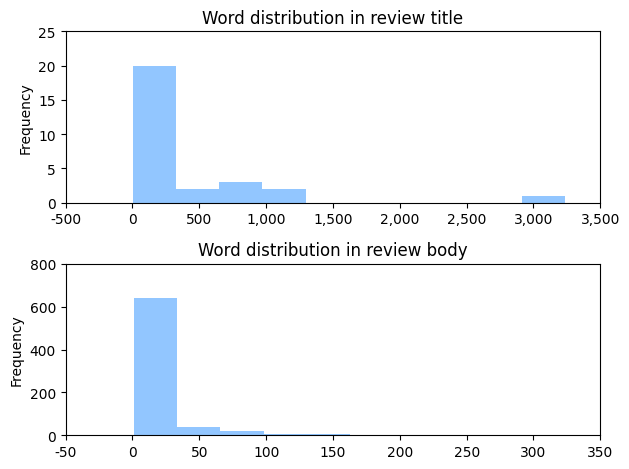

In [284]:
fig, axs = plt.subplots(2,1)

df['review_headline'].apply(lambda x: len(x.split())).value_counts().plot(kind='hist', ax=axs[0])
df['review_body'].apply(lambda x: len(x.split())).value_counts().plot(kind='hist', ax=axs[1])

axs[0].set_title('Word distribution in review title')
axs[1].set_title('Word distribution in review body')

for ax in axs:
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(f'{x:,.0f}' for x in ax.get_yticks())
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(f'{x:,.0f}' for x in ax.get_xticks())
fig.tight_layout();

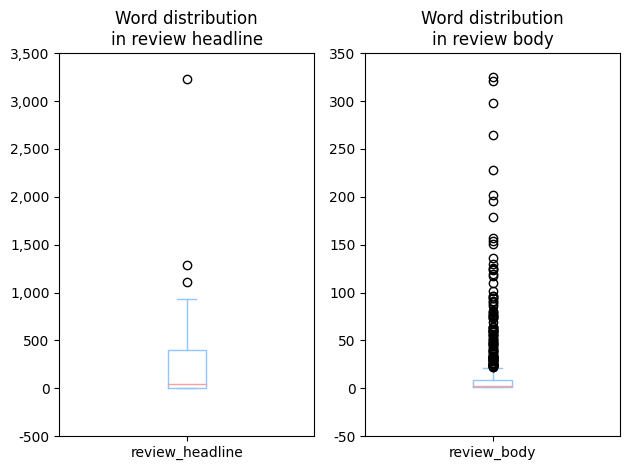

In [285]:
fig, axs = plt.subplots(1,2)

df['review_headline'].apply(lambda x: len(x.split())).value_counts().plot(kind='box', ax=axs[0])
df['review_body'].apply(lambda x: len(x.split())).value_counts().plot(kind='box', ax=axs[1])

axs[0].set_title('Word distribution\nin review headline')
axs[1].set_title('Word distribution\nin review body')

for ax in axs:
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(f'{x:,.0f}' for x in ax.get_yticks())
plt.tight_layout()

In [286]:
pd.DataFrame({'word_stats_headline': df['review_headline'].apply(lambda x: len(x.split())).describe(),
              'word_stats_body': df['review_body'].apply(lambda x: len(x.split())).describe()
              }).style.format('{:,.2f}')

,word_stats_headline,word_stats_body
count,"10,000.00","10,000.00"
mean,4.24,97.43
std,3.24,189.44
min,1.00,1.00
25%,2.00,20.00
50%,3.00,39.00
75%,6.00,97.00
max,29.00,"3,150.00"


### Emoticon analysis

In [287]:
# example of how use 'emoji' library
text_example = 'my opinion: 😄 Positive on this..., but 😭 Negative on this ... 👍'

# list emojis in text
emoji.emoji_list(text_example)

[{'match_start': 12, 'match_end': 13, 'emoji': '😄'},
 {'match_start': 39, 'match_end': 40, 'emoji': '😭'},
 {'match_start': 62, 'match_end': 63, 'emoji': '👍'}]

In [288]:
# 'demojize' text
print(emoji.demojize(text_example))

my opinion: :grinning_face_with_smiling_eyes: Positive on this..., but :loudly_crying_face: Negative on this ... :thumbs_up:


  0%|          | 0/10000 [00:00<?, ?it/s]

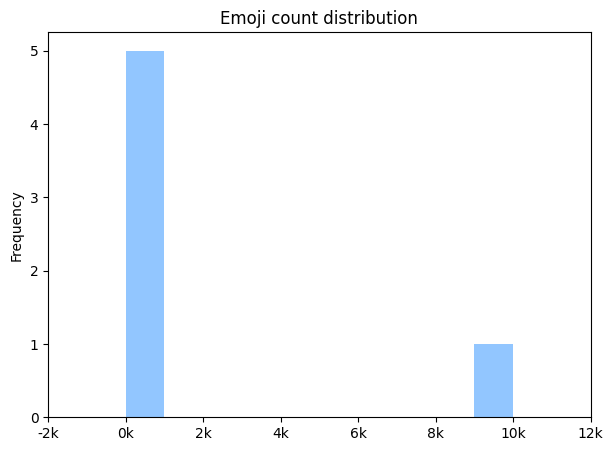

In [289]:
# count the amount of emojis in each document and plot distribution

emojis = df.review_body.progress_apply(lambda x: len(emoji.emoji_list(x)))
emojis.value_counts().plot(kind='hist', figsize=(7,5))
plt.gca().set_xticks(plt.gca().get_xticks())
plt.gca().set_xticklabels([f'{round(x/1000,2):,.0f}k' for x in plt.gca().get_xticks()])
plt.title('Emoji count distribution');

In [290]:
# emoji stats
emojis.value_counts().describe(percentiles=[.25,.5,.75,.9,.95,.99]).apply(lambda x: f'{x:,.2f}')

count        6.00
mean     1,666.67
std      4,075.14
min          1.00
25%          1.00
50%          1.50
75%          8.00
90%      4,997.50
95%      7,491.25
99%      9,486.25
max      9,985.00
Name: review_body, dtype: object

In [291]:
# check the top reviews with the highest emoji counts
df[df.index.isin(emojis.sort_values(ascending=False).head(3).index)][['review_id','product_title','star_rating','review_headline','review_body','review_date']]

,review_id,product_title,star_rating,review_headline,review_body,review_date
180063,R16UMWJYWWJCE6,Rayman Origins,5,Five Stars,I purchased this game for my baby 👶 boy and he...,2015-03-28
837932,RM7QLXO3JLF8M,ZZZ Mx Vs ATV Untamed,5,I used to play that game,It's cooler than other games. I looking this g...,2013-08-09
577758,R27WCWPGJBZ5CS,PlayStation 4 DualShock 4 Bundle,5,An Outstanding Experience Geared Toward Core G...,*** Key: ✔ Positive ✖ Negative ⓘ Informational...,2014-06-13


### Special character analysis

In [292]:
# count special characters being used by document. Common special characters are not being considered as "special"

special_characters = df.review_body.progress_apply(lambda x: re.sub(r"[a-zA-Z0-9 ,.\-:\?\!()']",'',x))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [293]:
# show some special characters found
special_characters_exploded = special_characters.apply(lambda x: np.unique([w.strip() for w in x])).explode()
special_characters_exploded[~special_characters_exploded.isnull()].unique()[:100]

c:\Users\Rodrigo\miniconda3\envs\py3108\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


array(['"', '/', '<', '>', '\\', '&', '%', ';', '~', '$', '@', '+', '#',
       '*', 'Ñ', '[', ']', '=', '_', '\x1a', '\ufeff', '®', '`', '…', '👏',
       'à', 'é', 'ñ', '—', '’', '´', '（', '“', '”', '！', 'á', '☺', '😉',
       '{', '}', '^', 'í', 'ú', '¡', '😄', '😡', '½', 'ó', '😕', '👍', '👶',
       '‘', '£', '😀', '😁', '😂', '😃', '😅', '😆', '😊', '😋', '😛', '😜', '😝',
       '😭', '😳', '\u200b', '\uf04a', '', '–', 'ⓘ', '✔', '✖', '💕', '€',
       'ō', '™', 'ê'], dtype=object)

### Word cloud 

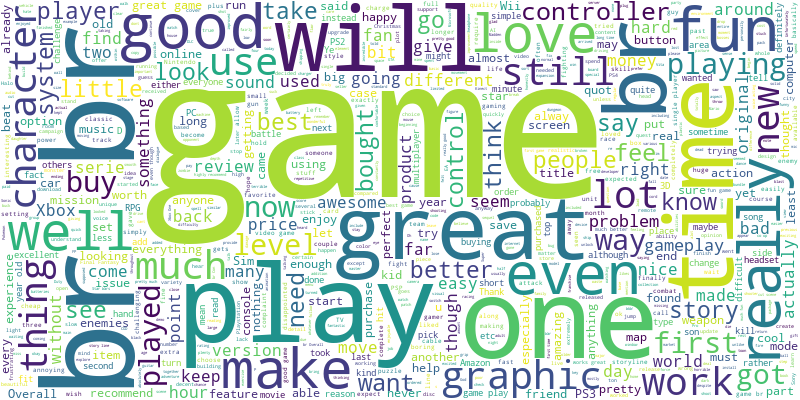

In [294]:
# Join the different processed titles together.
long_string = ','.join(df['review_body'].values)

# Create the WordCloud
wordcloud = WordCloud(background_color='white', max_words=5000, contour_width=3, contour_color='steelblue', width=800, height=400)
wordcloud.generate(long_string)
wordcloud.to_image()

# Text representation

## Pre-processing

In [3]:
def show_transformation(df, seed=18):
    with pd.option_context('display.max_colwidth', None):
        display(df[['review_body','review_body_preprocessed']].sample(1, random_state=seed))

In [4]:
# expand contractions
df['review_body_preprocessed']=df['review_body'].progress_apply(lambda x: contractions.fix(x))
show_transformation(df)

  0%|          | 0/10000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
1076058,"One of the best star wars games ever made. Mine arrived quickly, and in great shape, it was like new. Works great on an Xbox 360 and it's tons of fun to play with friends. A must have for any gaming collection!","One of the best star wars games ever made. Mine arrived quickly, and in great shape, it was like new. Works great on an Xbox 360 and it is tons of fun to play with friends. A must have for any gaming collection!"


In [5]:
# demojize texts
df['review_body_preprocessed']=df['review_body_preprocessed'].progress_apply(lambda x: emoji.demojize(x))
# look at a previous example
df.loc[577758, ['review_body','review_body_preprocessed']]

  0%|          | 0/10000 [00:00<?, ?it/s]

review_body                 *** Key: ✔ Positive ✖ Negative ⓘ Informational...
review_body_preprocessed    *** Key: :check_mark: Positive :multiply: Nega...
Name: 577758, dtype: object

In [6]:
# remove punctuation
string.punctuation
print(f'Punctuation list: {string.punctuation}')

def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

df['review_body_preprocessed']=df['review_body_preprocessed'].progress_apply(lambda x: remove_punctuation(x))
show_transformation(df)

Punctuation list: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


  0%|          | 0/10000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
1076058,"One of the best star wars games ever made. Mine arrived quickly, and in great shape, it was like new. Works great on an Xbox 360 and it's tons of fun to play with friends. A must have for any gaming collection!",One of the best star wars games ever made Mine arrived quickly and in great shape it was like new Works great on an Xbox 360 and it is tons of fun to play with friends A must have for any gaming collection


In [7]:
# keep alphabet chars only
def keep_alphabet_chars(text):
    return re.sub(r'[^a-zA-Z ]','',text)

df['review_body_preprocessed']=df['review_body_preprocessed'].progress_apply(lambda x: keep_alphabet_chars(x))
show_transformation(df)

  0%|          | 0/10000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
1076058,"One of the best star wars games ever made. Mine arrived quickly, and in great shape, it was like new. Works great on an Xbox 360 and it's tons of fun to play with friends. A must have for any gaming collection!",One of the best star wars games ever made Mine arrived quickly and in great shape it was like new Works great on an Xbox and it is tons of fun to play with friends A must have for any gaming collection


In [8]:
# lower casing
df['review_body_preprocessed']=df['review_body_preprocessed'].str.lower()
show_transformation(df)

,review_body,review_body_preprocessed
1076058,"One of the best star wars games ever made. Mine arrived quickly, and in great shape, it was like new. Works great on an Xbox 360 and it's tons of fun to play with friends. A must have for any gaming collection!",one of the best star wars games ever made mine arrived quickly and in great shape it was like new works great on an xbox and it is tons of fun to play with friends a must have for any gaming collection


In [9]:
# remove stop words
en_stopwords = stopwords.words('english') + ['br','one']

def remove_stopwords(text, en_stopwords):
    result = []
    for token in text.split():
        if token not in en_stopwords:
            result.append(token)
    return ' '.join(result)

df['review_body_preprocessed']=df['review_body_preprocessed'].progress_apply(lambda x: remove_stopwords(x, en_stopwords))
show_transformation(df)

  0%|          | 0/10000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
1076058,"One of the best star wars games ever made. Mine arrived quickly, and in great shape, it was like new. Works great on an Xbox 360 and it's tons of fun to play with friends. A must have for any gaming collection!",best star wars games ever made mine arrived quickly great shape like new works great xbox tons fun play friends must gaming collection


In [10]:
# lemmatize words
lemmatizer = WordNetLemmatizer()

def lemmatize(text, lemmatizer):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(lemmatized_words)

df['review_body_preprocessed']=df['review_body_preprocessed'].progress_apply(lambda x: lemmatize(x, lemmatizer))
show_transformation(df)

  0%|          | 0/10000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
1076058,"One of the best star wars games ever made. Mine arrived quickly, and in great shape, it was like new. Works great on an Xbox 360 and it's tons of fun to play with friends. A must have for any gaming collection!",best star war game ever made mine arrived quickly great shape like new work great xbox ton fun play friend must gaming collection


In [11]:
# stemming words
from  nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stemming(text, stemmer):
    stem = [stemmer.stem(word) for word in text.split()]
    return ' '.join(stem)

df['review_body_preprocessed_stem']=df['review_body_preprocessed'].progress_apply(lambda x: stemming(x, stemmer))
# compare lemmatization and stemming
with pd.option_context('display.max_colwidth', None):
    display(df[['review_body','review_body_preprocessed','review_body_preprocessed_stem']].sample(1, random_state=18))

  0%|          | 0/10000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed,review_body_preprocessed_stem
1076058,"One of the best star wars games ever made. Mine arrived quickly, and in great shape, it was like new. Works great on an Xbox 360 and it's tons of fun to play with friends. A must have for any gaming collection!",best star war game ever made mine arrived quickly great shape like new work great xbox ton fun play friend must gaming collection,best star war game ever made mine arriv quickli great shape like new work great xbox ton fun play friend must game collect


## BoW

In [12]:
def jaccard_similarity(x,y):
    """ returns the jaccard similarity between two lists """
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

def euclidean_distance(x,y):
    """ return euclidean distance between two lists """
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

def cosine_similarity(x,y):
    """ return cosine similarity between two lists """
    def squared_sum(x):
        """ return 3 rounded square rooted value """
        return round(sqrt(sum([a*a for a in x])),3)
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = squared_sum(x)*squared_sum(y)
    return round(numerator/float(denominator),3)

def show_similarity_with_docs(vector, df_vectors, df, n_samples=5, seed=18):
    samples = df_vectors.sample(n_samples, random_state=seed)

    for index, sample in samples.iterrows():
        with pd.option_context('display.max_colwidth', None):
            display(df[df.index == index][['review_id','product_title','review_body']])
        print(f"Jaccard similarity: {round(jaccard_similarity(vector, sample.values),4)}")
        print(f"Euclidean similarity: {round(euclidean_distance(vector, sample.values),4)}")
        print(f"Cosine similarity: {round(cosine_similarity(vector, sample.values),4)}")

In [313]:
bow_vectorizer = CountVectorizer(ngram_range=(1,1)) # indicates it will extract from just unigrams
bow_matrix = bow_vectorizer.fit_transform(df.review_body_preprocessed)
bow_matrix.shape

(10000, 29607)

In [315]:
df_bow = pd.DataFrame(bow_matrix.toarray(), index=df.index, columns=bow_vectorizer.vocabulary_)
df_bow.head(3)

,really,checked,earlier,later,due,system,requirement,high,version,ea,...,blather,avoidable,onset,troupe,developmentally,hormone,begrudge,shallowness,scorned,mocked
1660627,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1232608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
508804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [324]:
sample = df.sample(1, random_state=18)[['review_id','product_title','review_body']]
sample_vector = df_bow.loc[sample.index[0]]
with pd.option_context('display.max_colwidth', None):
    display(sample)

,review_id,product_title,review_body
1076058,R1PCROW31YBPRI,Star Wars Battlefront II,"One of the best star wars games ever made. Mine arrived quickly, and in great shape, it was like new. Works great on an Xbox 360 and it's tons of fun to play with friends. A must have for any gaming collection!"


In [317]:
show_similarity_with_docs(sample_vector.values, df_bow, df, n_samples=3)

,review_id,product_title,review_body
1076058,R1PCROW31YBPRI,Star Wars Battlefront II,"One of the best star wars games ever made. Mine arrived quickly, and in great shape, it was like new. Works great on an Xbox 360 and it's tons of fun to play with friends. A must have for any gaming collection!"


Jaccard similarity: 1.0
Euclidean similarity: 0.0
Cosine similarity: 1.0


,review_id,product_title,review_body
483665,R1NODZJ10Q4S0Y,inFAMOUS Second Son - PlayStation 4,Suck it you stupid xbox users.


Jaccard similarity: 0.6667
Euclidean similarity: 5.1962
Cosine similarity: 0.1


,review_id,product_title,review_body
35948,R15PA3APAUOGGG,Nyko Charge Station for Wii (Black),Several years later still recharging my remotes like a champ.


Jaccard similarity: 0.6667
Euclidean similarity: 5.5678
Cosine similarity: 0.071


## TF-IDF

In [320]:
tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
tf_idf_matrix = tf_idf_vectorizer.fit_transform(df.review_body_preprocessed)
tf_idf_matrix.shape

(10000, 29607)

In [321]:
df_tfidf = pd.DataFrame(tf_idf_matrix.toarray(), index=df.index, columns=tf_idf_vectorizer.vocabulary_)
df_tfidf.head(3)

,really,checked,earlier,later,due,system,requirement,high,version,ea,...,blather,avoidable,onset,troupe,developmentally,hormone,begrudge,shallowness,scorned,mocked
1660627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1232608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
508804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [325]:
show_similarity_with_docs(sample_vector.values, df_tfidf, df, n_samples=3, seed=10)

,review_id,product_title,review_body
842140,R22KOHQGP67BSC,Borderlands 2,"One of my favorite franchises, the Borderlands games are super fun and also funny. Totally recommend it if you like shooting games with a little comedy mixed in."


Jaccard similarity: 0.0556
Euclidean similarity: 5.0151
Cosine similarity: 0.085


,review_id,product_title,review_body
714412,R2YXG2H7F2X6Z2,Animal Crossing: New Leaf,"This game is so fun and I urge every 3DS owner to purchase it. And not just kids! You can go online and visit other people's villages, and I have mostly met teens around 16-19 years old, and even some people that are 30-40! It's a universally fun game with a childish package, but trust me, anyone will love it."


Jaccard similarity: 0.037
Euclidean similarity: 5.0385
Cosine similarity: 0.061


,review_id,product_title,review_body
849754,R2OYDSLUTYYL5M,Fight Night Champion - Playstation 3,Crashes when you make to many fighters. But otherwise use great game. I bought the Xbox just for this game.


Jaccard similarity: 0.0769
Euclidean similarity: 4.9211
Cosine similarity: 0.178


## Fasttext

In [13]:
# Load the FastText model
model = fasttext.load_model('../models/crawl-300d-2M.vec')

In [ ]:
# Preprocess the text
text1 = 'This is a piece of text'
text2 = 'This is another piece of text'
tokens1 = fasttext.tokenize(text1)
tokens2 = fasttext.tokenize(text2)
tokens1 = [token.lower() for token in tokens1]
tokens2 = [token.lower() for token in tokens2]

# Generate word vectors for each piece of text
vector1 = model.get_sentence_vector(tokens1)
vector2 = model.get_sentence_vector(tokens2)

# Calculate the similarity between the vectors using cosine similarity
from scipy.spatial.distance import cosine
similarity = 1 - cosine(vector1, vector2)
print('Similarity:', similarity)

Exception: fastText: Cannot load ../models/crawl-300d-2M.vec due to C++ extension failed to allocate the memory

In [ ]:
fasttext_vectors = df.review_body.apply(lambda x: model.get_sentence_vector(x))

## T-SNE

# Topic modeling

In [11]:
# Remove punctuation
df['review_body_preprocessed'] = df['review_body'].apply(lambda x: re.sub(r"[,\.!?]", '', x))
# Convert the titles to lowercase
df['review_body_preprocessed'] = df['review_body'].apply(lambda x: x.lower())

In [12]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data = df.review_body.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

['really', 'checked', 'earlier', 'later', 'due', 'system', 'requirements', 'high', 'versions', 'ea', 'sport', 'nhl', 'games', 'pc', 'quite', 'nicely', 'long', 'time', 'even', 'get', 'faster', 'better', 'computer', 'someday', 'pentium', 'iii', 'mhz', 'hard', 'drive', 'ram']


In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 2), (3, 2), (4, 1), (5, 1), (6, 3), (7, 2), (8, 2), (9, 1), (10, 1), (11, 2), (12, 1), (13, 2), (14, 1), (15, 8), (16, 6), (17, 1), (18, 1), (19, 2), (20, 2), (21, 2), (22, 1), (23, 2), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 2)]


In [15]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                    id2word=id2word,
                                    num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.027*"game" + 0.011*"like" + 0.010*"br" + 0.010*"great" + 0.007*"would" + '
  '0.006*"good" + 0.006*"get" + 0.006*"got" + 0.005*"one" + 0.005*"games"'),
 (1,
  '0.024*"br" + 0.020*"game" + 0.010*"like" + 0.009*"one" + 0.008*"games" + '
  '0.007*"get" + 0.006*"good" + 0.006*"time" + 0.006*"really" + 0.005*"much"'),
 (2,
  '0.037*"game" + 0.008*"one" + 0.008*"really" + 0.007*"playing" + '
  '0.006*"games" + 0.006*"br" + 0.006*"get" + 0.005*"good" + '
  '0.005*"controller" + 0.005*"work"'),
 (3,
  '0.054*"game" + 0.013*"like" + 0.010*"br" + 0.010*"play" + 0.009*"get" + '
  '0.009*"one" + 0.008*"fun" + 0.008*"great" + 0.007*"good" + 0.007*"time"'),
 (4,
  '0.016*"br" + 0.009*"one" + 0.009*"game" + 0.007*"would" + 0.006*"great" + '
  '0.006*"like" + 0.006*"games" + 0.006*"well" + 0.006*"xbox" + 0.006*"still"'),
 (5,
  '0.044*"game" + 0.019*"br" + 0.012*"play" + 0.011*"games" + 0.010*"great" + '
  '0.009*"one" + 0.008*"fun" + 0.007*"get" + 0.006*"would" + 0.006*"much"'),
 (6,
  '0.0

In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('../topic_modeling/ldavis_prepared_'+str(num_topics))

# if you want to execute visualization prep yourself

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, '../topic_modeling/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.032420  0.007145       1        1  22.691237
9     -0.024457 -0.001444       2        1  13.800176
8     -0.006931 -0.033025       3        1  13.349594
5     -0.017449 -0.000167       4        1  11.941899
1     -0.011945 -0.014334       5        1  10.430641
4      0.035410 -0.009594       6        1   8.088935
6      0.042847 -0.002102       7        1   7.235023
7      0.005981  0.019589       8        1   5.235070
0      0.007814  0.010043       9        1   4.158005
2      0.001149  0.023889      10        1   3.069420, topic_info=           Term           Freq          Total Category  logprob  loglift
15           br  116088.000000  116088.000000  Default  30.0000  30.0000
64         game  160897.000000  160897.000000  Default  29.0000  29.0000
29   controller   12647.000000   12647.000000  Default  28.0000  28.0000
74        great   34697.000000   34697.000000  Default  27.0000  27.0000
119         one   40642.000000   40642.000000  Default  26.0000  26.0000
..          ...            ...            ...      ...      ...      ...
96         love     466.125917   13385.624603  Topic10  -5.7838   0.1262
15           br     867.354194  116088.573049  Topic10  -5.1628  -1.4130
336         fun     542.839076   25720.561988  Topic10  -5.6315  -0.3746
186        time     480.465402   27104.130845  Topic10  -5.7535  -0.5490
16          buy     458.103812   14338.755492  Topic10  -5.8012   0.0401

[921 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
26546      2  0.038299   aaaa
26546      6  0.919165   aaaa
26546      9  0.038299   aaaa
26547      6  0.857474  aaaaa
1302       1  0.145438   able
...      ...       ...    ...
3205       6  0.061068  zumba
3205       7  0.023264  zumba
3205       8  0.308250  zumba
3205       9  0.029080  zumba
3205      10  0.002908  zumba

[3053 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 9, 6, 2, 5, 7, 8, 1, 3])